In [1]:
from transformers import GPT2LMHeadModel

/home/aravind/gpt2/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

# getting the model architecture of gpt2 from huggingface transformers

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
sd_hf['transformer.wpe.weight'].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf['transformer.wpe.weight'], cmap = "grey")

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150], color='black')
plt.plot(sd_hf["transformer.wpe.weight"][:, 200], color='red')
plt.plot(sd_hf["transformer.wpe.weight"][:, 250], color='blue')

In [ ]:
plt.imshow(sd_hf['transformer.h.1.attn.c_attn.weight'], cmap = "grey")

In [ ]:
# sampling from the model
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a big fan of", max_length=30, num_return_sequences=5)


In [ ]:
# loading the tiny shakespeare dataset
with open('input.txt', 'r') as f:
    text  = f.read()
data = text[:1000]

# gpt2 has a compression ratio of about 3x


In [ ]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:20])


In [ ]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)

print(x)
print(y)


In [ ]:
# both lm_head.weight and transofrmer.wte.weight are tied


### ideas behind speeding up the training
1. torch by default has precision float32, but apparently float16 is enough for training large language models, since we don't need high precision floating numbers. Around 16 times faster computation is obtained compared to float 32. First iteration is slow, but after that it is much faster.
2. torch.compile is a compiler for neural networks. it will know all operations to be used and then it will optimize the process
3. flash attention is a kernel fusion operation that torch.compile cannout find. it is approximately 7.6x faster. 
4. Scan the code and look for numbers that are not exponents of 2. 



Min Train Loss: 3.690568
Min Validation Loss: 3.929175
Max Hellaswag eval: 0.258116


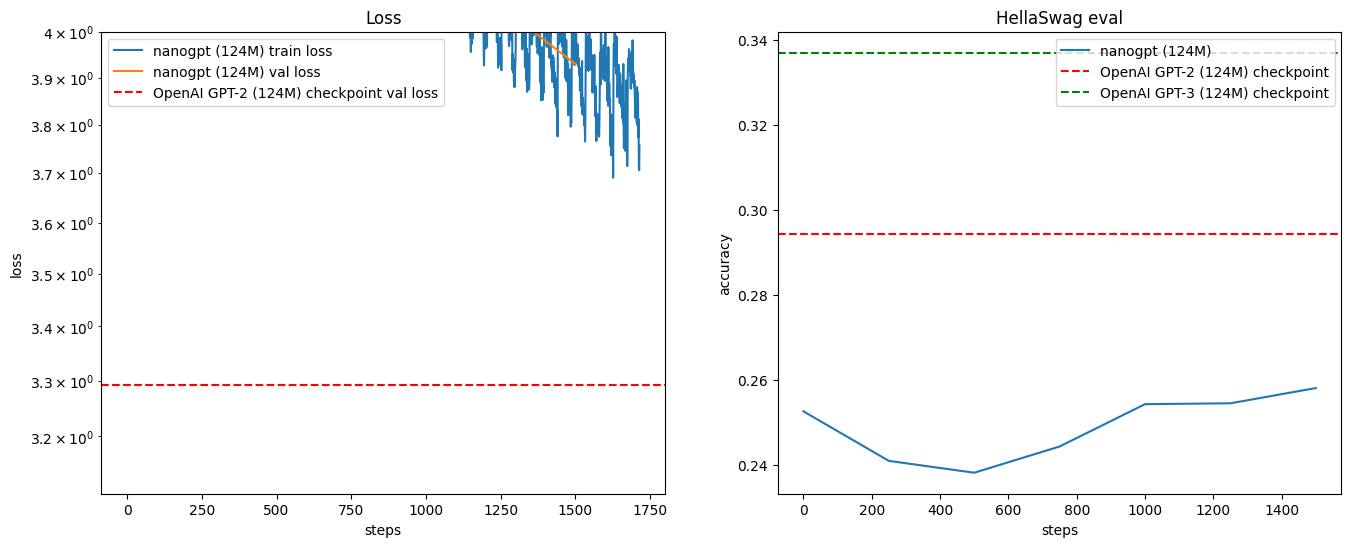

In [2]:
## Hyperparameter tuning
# 1. Optimizing the optimizer based on the paper
# 2. change learning rate: warmup and then cosine decay
# 3. gradient accumulation : it is a technique to simulate a larger batch size. 
# 4. distributed data parallel training
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")

print("Max Hellaswag eval:", max(ys))
